### YUGESHWARAN GUNASEKAR
### 1230777186

# Beer Brewing Optimization Process
This project aims to optimize the beer brewing process. The brewing parameters such as temperature, fermentation rate, and ingredient ratios to produce the best quality beer.


In [ ]:
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

# Constants for Beer Brewing
FERMENTATION_RATE = 0.05  #rate of fermentation
TEMPERATURE_OPTIMAL = 22.0  #optimal temperature
TEMPERATURE_RANGE = 2.0  #temperature variation
INGREDIENT_RATIO = 0.1  #ingredient ratio

# Objective Function

The quality of the brew is evaluated using the following objective function, which is to be minimized:

$$ 	ext{Quality} = |T - T_{	ext{optimal}}| + |F - 1.0| $$


# Brewing Simulation Documentation

This document provides a detailed overview of the brewing simulation implemented using PyTorch, focusing on the mathematical formulations.

## Problem Formulation

The objective of the simulation is to optimize the brewing process for achieving the best beer quality. This involves managing various parameters such as temperature, fermentation level, and ingredient concentration.

### Variables

1. **State Variables:**
   - Temperature: $ T $
   - Fermentation Level: $ F $
   - Ingredient Concentration: $ I $

2. **Action Variables:**
   - Temperature Adjustment: $$ \Delta T \$$

   - Ingredient Adjustment: $$ \Delta I \ $$

### Dynamics

The state of the brewing process is updated based on the following dynamics:


1. Temperature Update:
   $$ T_{\text{new}} = T + \Delta T - (T - T_{\text{optimal}}) \times \text{FERMENTATION\_RATE} $$

2. Fermentation Update:
   $$ F_{\text{new}} = F + \text{FERMENTATION\_RATE} \times I $$

3. Ingredient Update:
   $$ I_{\text{new}} = I + \Delta I $$
### Constraints


- Temperature should be maintained within an optimal range:
  $$ T_{\text{optimal}} \pm \text{TEMPERATURE\_RANGE} $$

- Fermentation level should ideally reach 1.0, indicating complete fermentation:
  $$ F \rightarrow 1.0 $$

- Ingredient concentration adjustments are based on specific recipe requirements:
  $$ \Delta I \ $$

### Assumptions

- The fermentation rate is assumed to be constant throughout the process.
- The optimal temperature for brewing is considered a fixed value.
- External factors such as humidity are not considered in this simulation.


---


In [ ]:
class BrewingDynamics(nn.Module):
    def __init__(self):
        super(BrewingDynamics, self).__init__()

    def forward(self, state, action):
        """
        state[0] = current temperature
        state[1] = fermentation level
        state[2] = ingredient concentration

        action[0] = temperature adjustment
        action[1] = ingredient adjustment
        """
        if action.shape[1] < state.shape[1]:
            padding_size = state.shape[1] - action.shape[1]
            padding = torch.zeros(action.size(0), padding_size, device=action.device)
            action = torch.cat((action, padding), dim=1)

        #temperature dynamics
        delta_temp = action[:, 0] - (state[:, 0] - TEMPERATURE_OPTIMAL) * FERMENTATION_RATE

        #fermentation dynamics
        fermentation_progress = FERMENTATION_RATE * state[:, 2]  # Fermentation depends on ingredient concentration

        #ingredient dynamics
        ingredient_change = action[:, 1]

        #update state
        new_state = state + torch.stack([delta_temp, fermentation_progress, ingredient_change], dim=1)
        return new_state

In [ ]:
class BrewingController(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        super(BrewingController, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        return action

In [ ]:
class BrewingSimulation(nn.Module):
    def __init__(self, controller, dynamics, T):
        super(BrewingSimulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.state_trajectory = []

    def forward(self, state):
        self.state_trajectory = []
        for _ in range(self.T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            if state.shape[1] != 3:
                raise ValueError(f"State should have 3 elements, but has {state.shape[1]} elements")

            self.state_trajectory.append(state.clone())
        return self.evaluate_brew_quality(state)

    @staticmethod
    def initialize_state():
        return torch.tensor([[TEMPERATURE_OPTIMAL, 0., INGREDIENT_RATIO]], requires_grad=False).float()


    def evaluate_brew_quality(self, state):
        temperature_penalty = torch.abs(state[0, 0] - TEMPERATURE_OPTIMAL)
        fermentation_completion = torch.abs(state[0, 1] - 1.0)
        return temperature_penalty + fermentation_completion

In [ ]:
class BrewOptimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
        self.loss_list = []

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()


    def train(self, epochs):
        self.epoch_state_history = []
        for epoch in range(epochs):
            loss = self.step()
            self.loss_list.append(loss.item())
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.plot_simulation()
            final_state = self.simulation.state.clone()
            self.epoch_state_history.append(final_state)


    def plot_simulation(self):
        temperature_data = []
        fermentation_data = []
        ingredient_data = []
        state = self.simulation.state

        for _ in range(self.simulation.T):
            action = self.simulation.controller(state)
            state = self.simulation.dynamics(state, action)
            temperature_data.append(state[0, 0].item())
            fermentation_data.append(state[0, 1].item())
            ingredient_data.append(state[0, 2].item())

        # Time steps for plotting
        time_steps = list(range(self.simulation.T))
        plt.figure(figsize=(12, 4))

        # Temperature plot
        plt.subplot(1, 3, 1)
        plt.plot(time_steps, temperature_data, label='Temperature', color='red')
        plt.axhline(y=TEMPERATURE_OPTIMAL, color='green', linestyle='--')
        plt.title('Temperature Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Temperature (Celsius)')
        plt.legend()

        # Fermentation plot
        plt.subplot(1, 3, 2)
        plt.plot(time_steps, fermentation_data, label='Fermentation Level', color='blue')
        plt.title('Fermentation Level Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Fermentation Level')
        plt.legend()

        # Ingredient Concentration plot
        plt.subplot(1, 3, 3)
        plt.plot(time_steps, ingredient_data, label='Ingredient Concentration', color='purple')
        plt.title('Ingredient Concentration Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Ingredient Concentration')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_convergence_curve(self):
        plt.figure()
        plt.plot(self.loss_list, label='Loss over Epochs')
        plt.title('Objective Function Convergence')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def animate_brewing_process_3d(self, filename='/mnt/data/brewing_process_3d.gif'):
        if not self.simulation.state_trajectory:
            raise ValueError("State trajectory is empty. Run the simulation forward method first.")
        print("Length of state_trajectory:", len(self.simulation.state_trajectory))
        temperature_data = [state[0, 0].item() for state in self.simulation.state_trajectory]
        fermentation_data = [state[0, 1].item() for state in self.simulation.state_trajectory]
        ingredient_data = [state[0, 2].item() for state in self.simulation.state_trajectory]

        #3D animation
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Temperature (°C)')
        ax.set_zlabel('Level / Concentration')
        ax.set_title('Brewing Process Visualization')
        line_fermentation, = ax.plot([], [], [], label='Fermentation Level', color='g', linewidth=2)
        line_ingredient, = ax.plot([], [], [], label='Ingredient Concentration', color='b', linewidth=2)
        ax.set_xlim(0, len(temperature_data))
        ax.set_ylim(min(temperature_data), max(temperature_data))
        ax.set_zlim(0, max(max(fermentation_data), max(ingredient_data)))

        def init():
            line_fermentation.set_data([], [])
            line_fermentation.set_3d_properties([])
            line_ingredient.set_data([], [])
            line_ingredient.set_3d_properties([])
            return line_fermentation, line_ingredient

        # Animation function
        def animate(i):
            x = np.arange(i + 1)
            y = temperature_data[:i + 1]
            z1 = fermentation_data[:i + 1]
            z2 = ingredient_data[:i + 1]

            line_fermentation.set_data(x, y)
            line_fermentation.set_3d_properties(z1)
            line_ingredient.set_data(x, y)
            line_ingredient.set_3d_properties(z2)

            return line_fermentation, line_ingredient

        anim = FuncAnimation(fig, animate, init_func=init, frames=len(temperature_data), interval=100, blit=True)

        anim.save(filename, writer=PillowWriter(fps=24))

        plt.close()

        return filename

[1] loss: 49.829


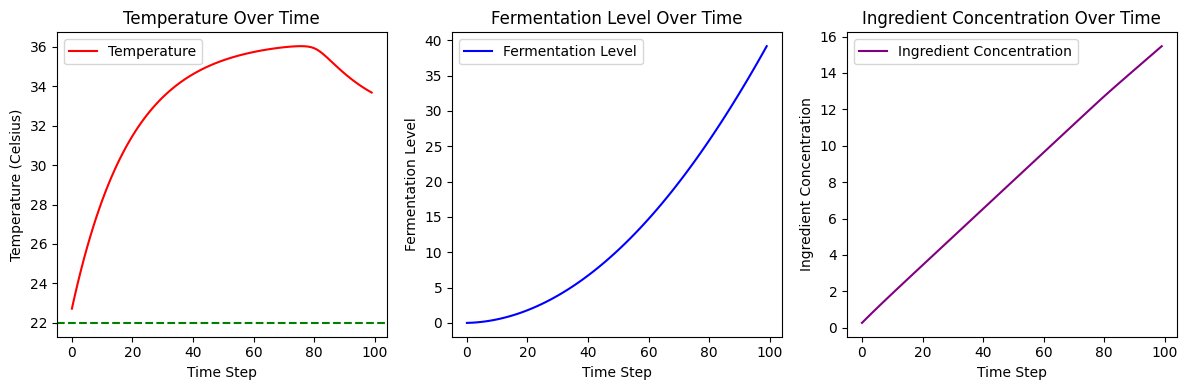

[2] loss: 22.569


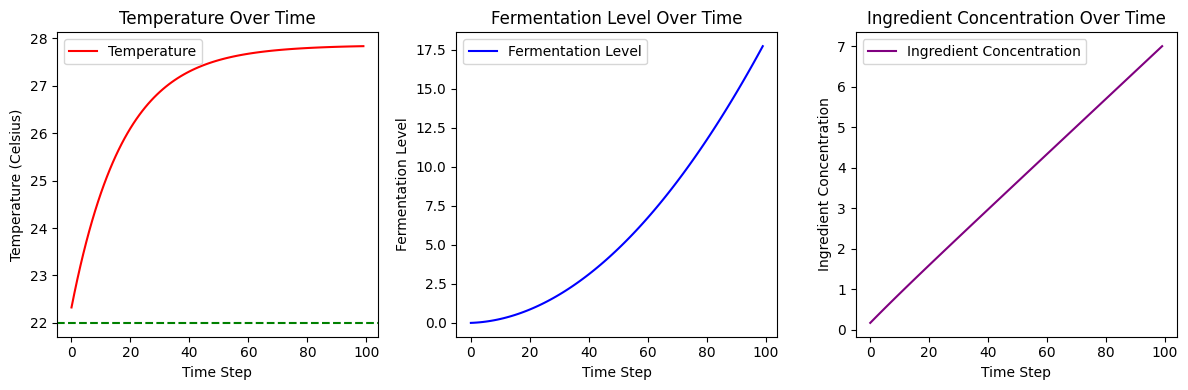

[3] loss: 17.560


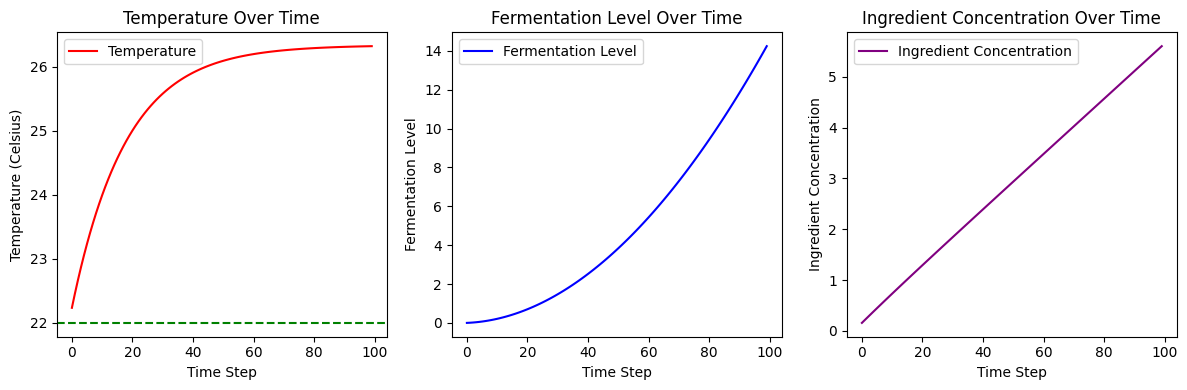

[4] loss: 13.876


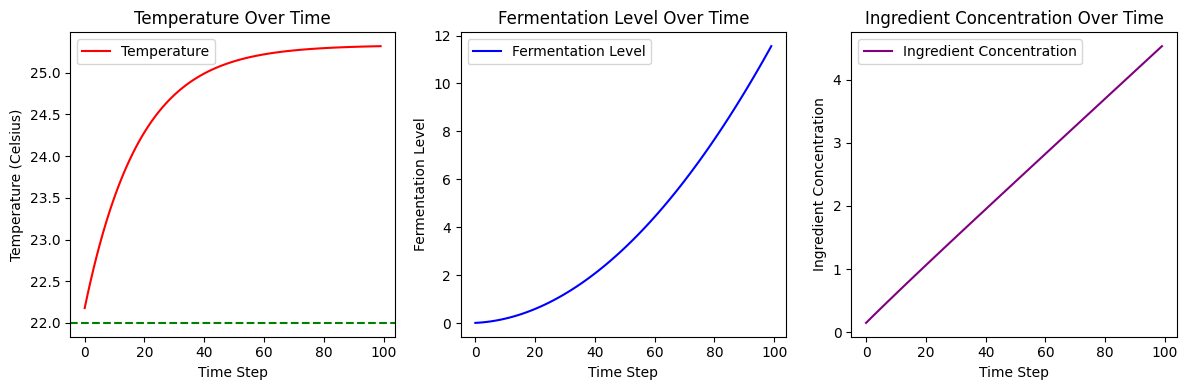

[5] loss: 11.042


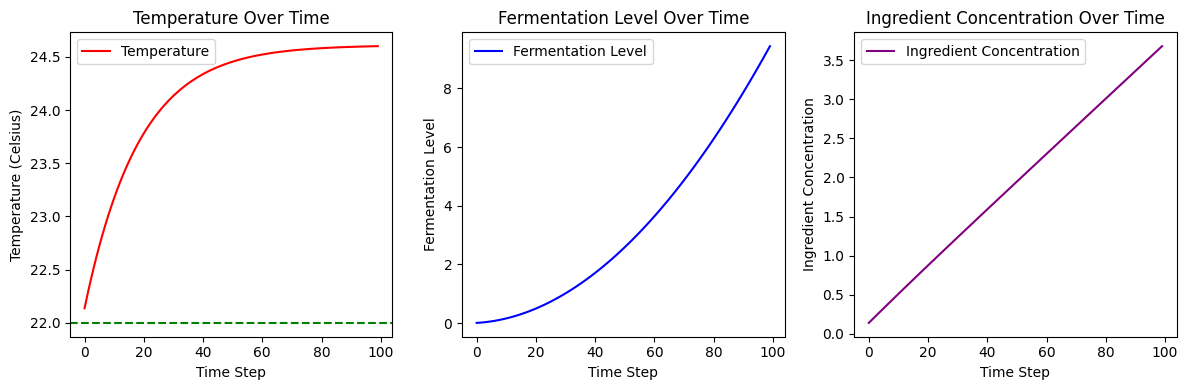

[6] loss: 8.814


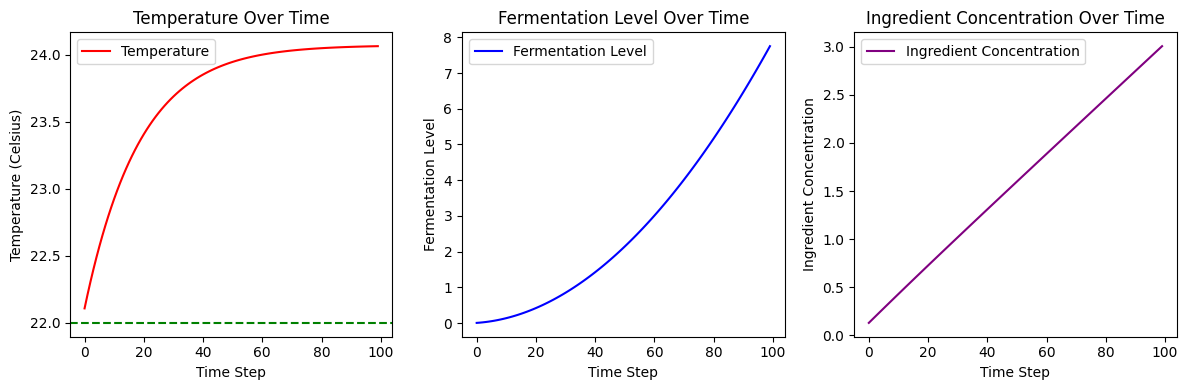

[7] loss: 7.042


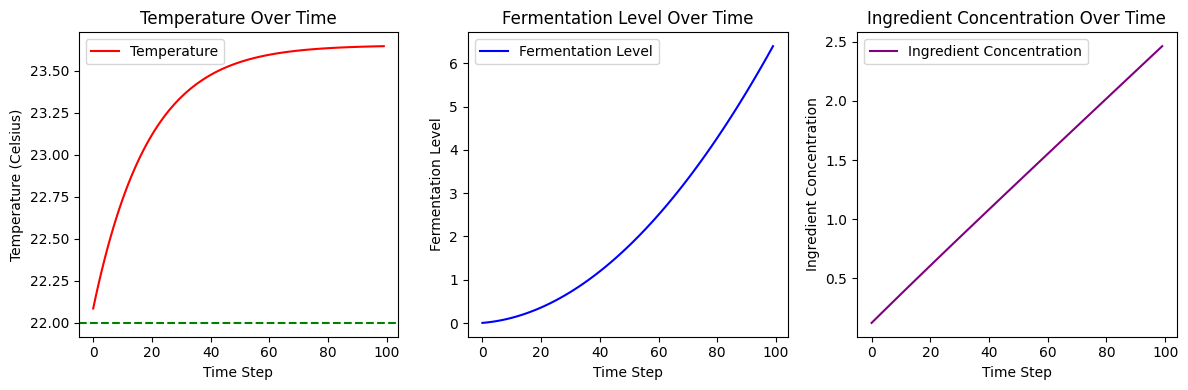

[8] loss: 5.606


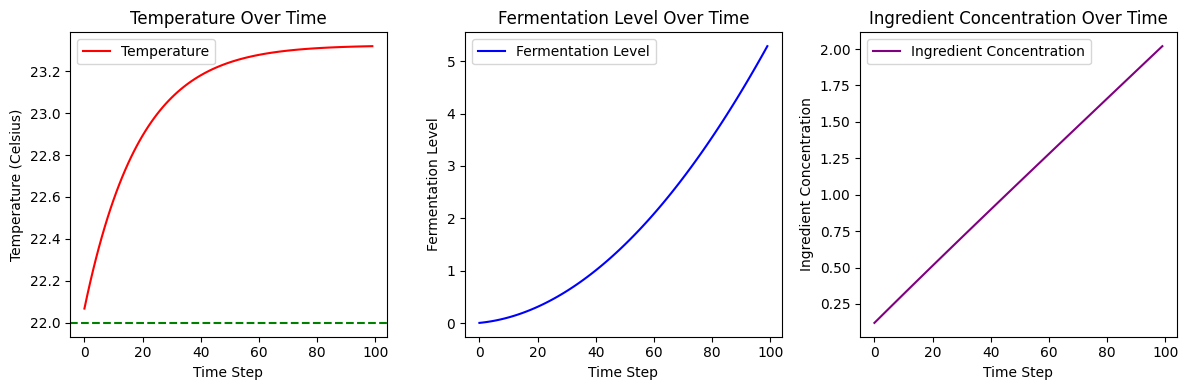

[9] loss: 4.463


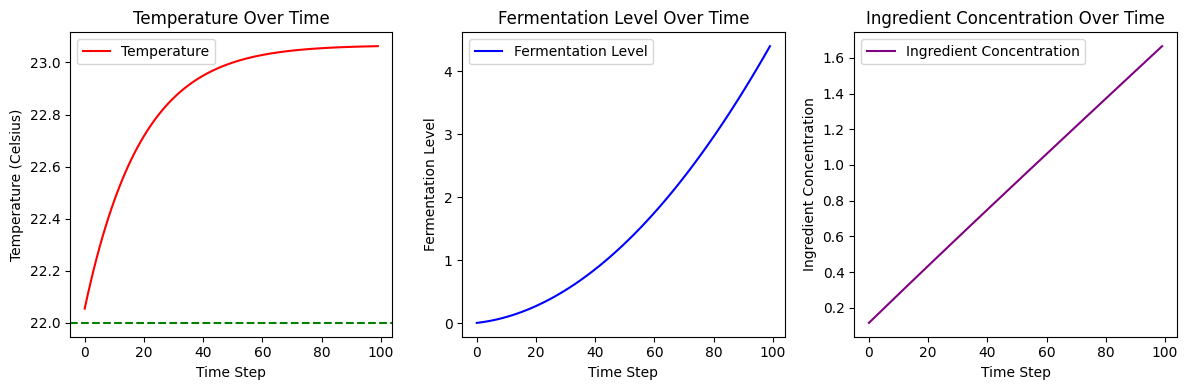

[10] loss: 3.540


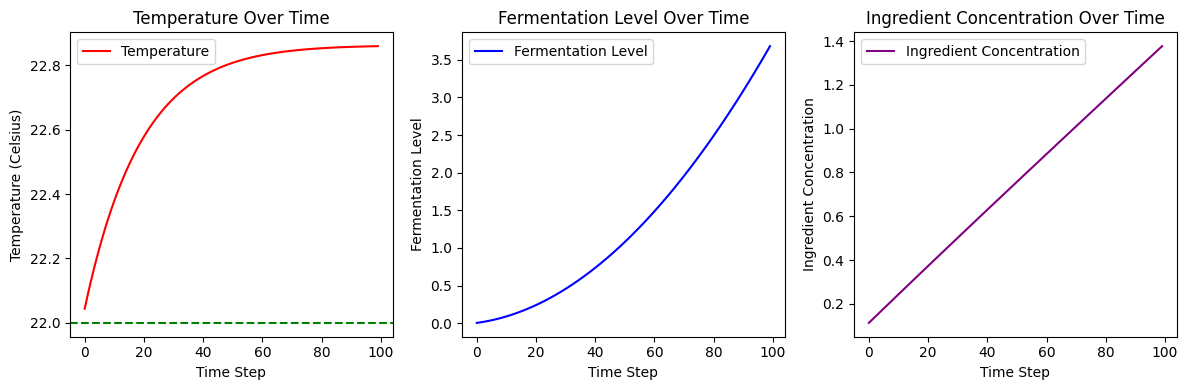

[11] loss: 2.792


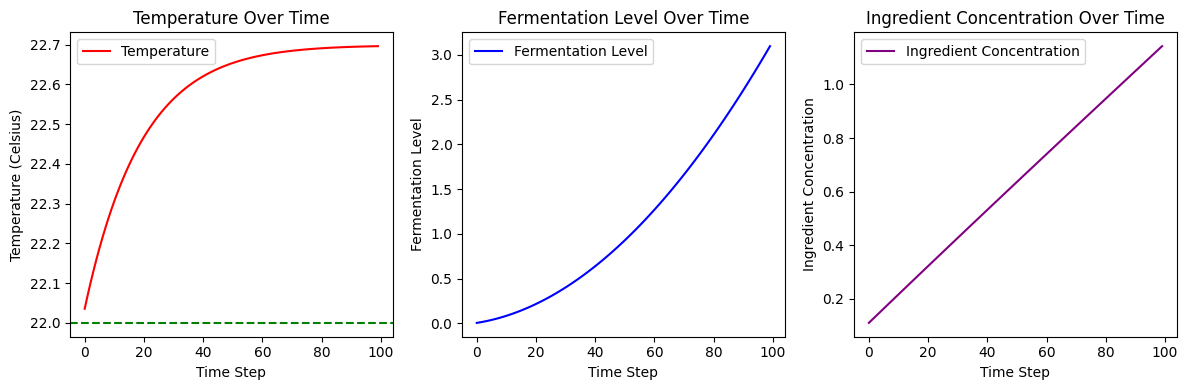

[12] loss: 2.185


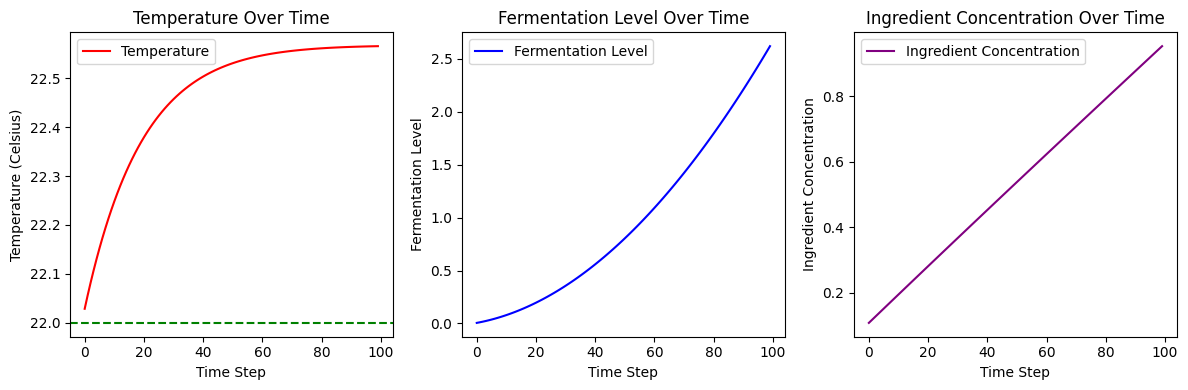

[13] loss: 1.688


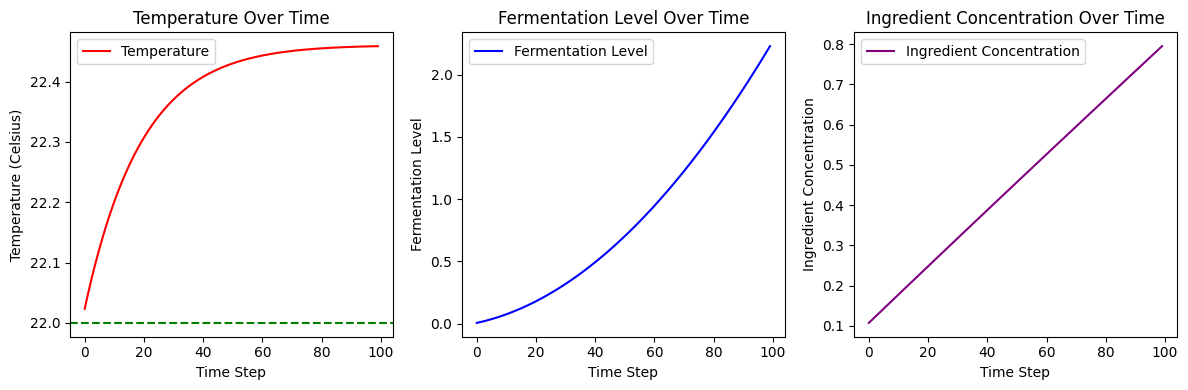

[14] loss: 1.286


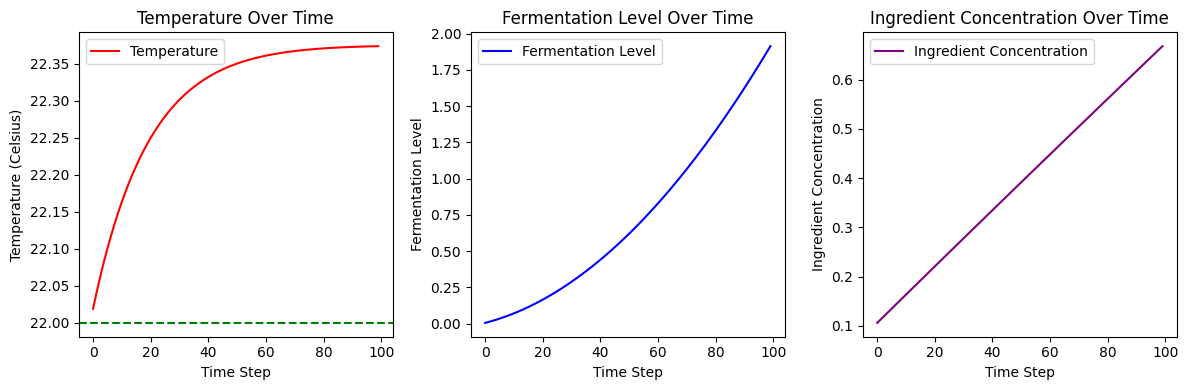

[15] loss: 0.960


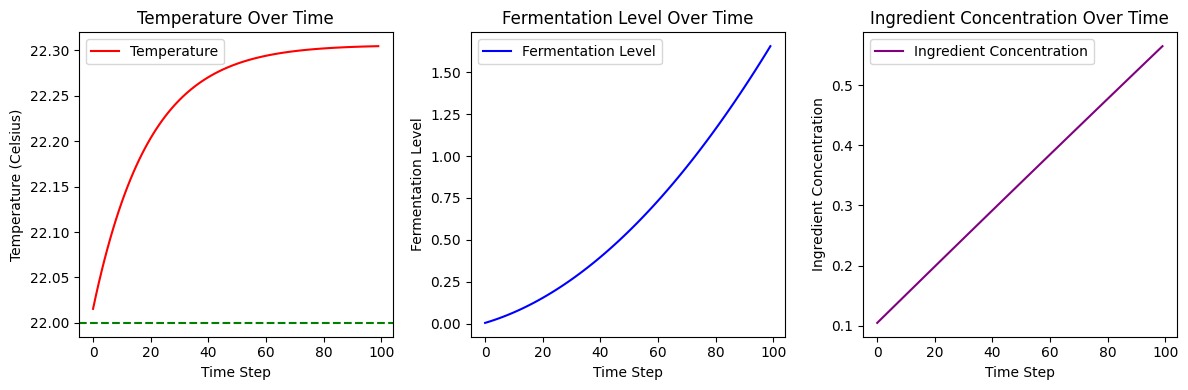

[16] loss: 0.693


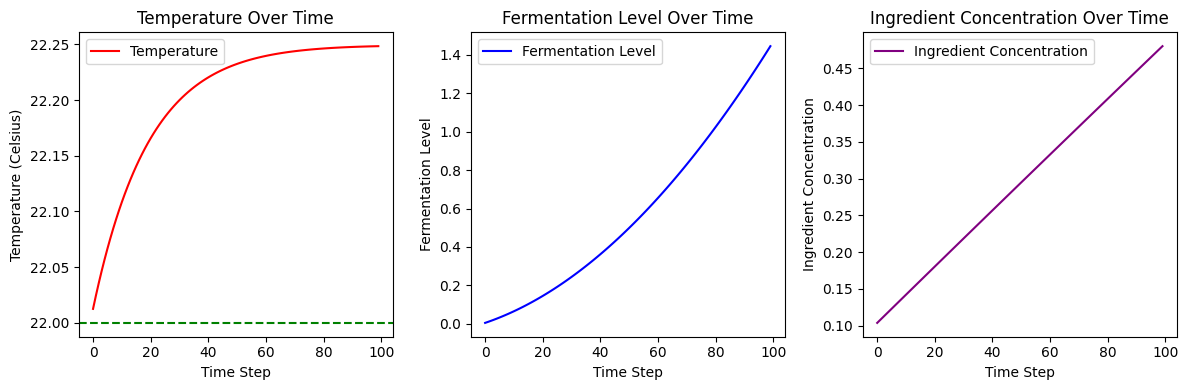

[17] loss: 0.476


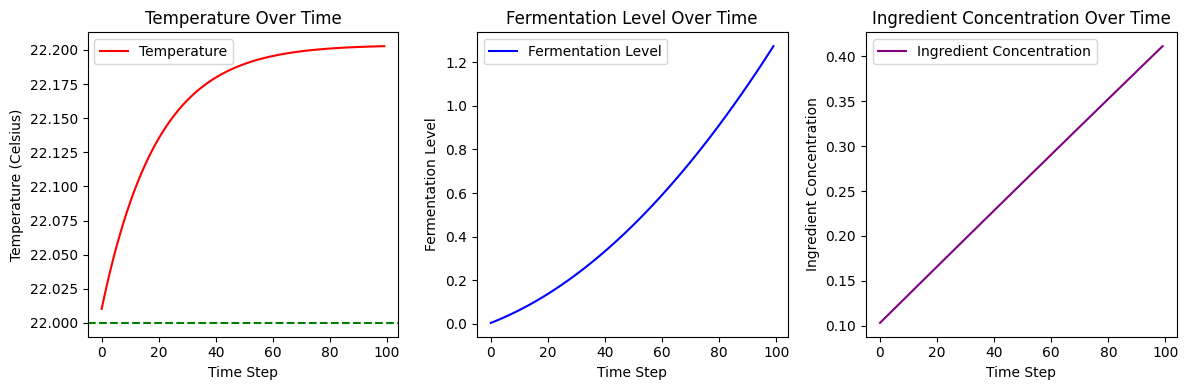

[18] loss: 0.298


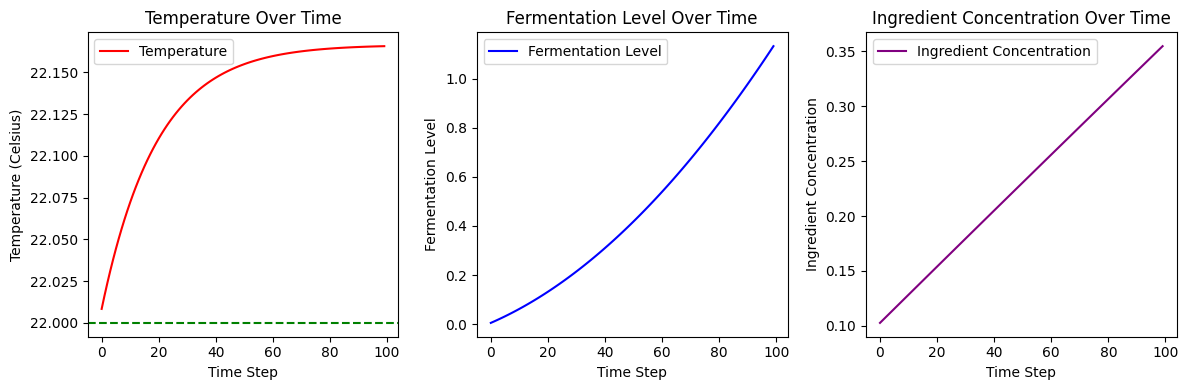

[19] loss: 0.152


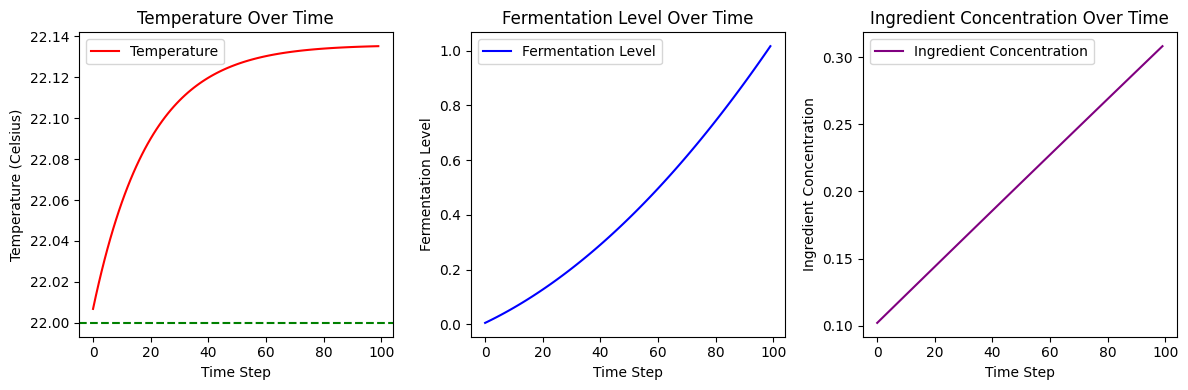

[20] loss: 0.133


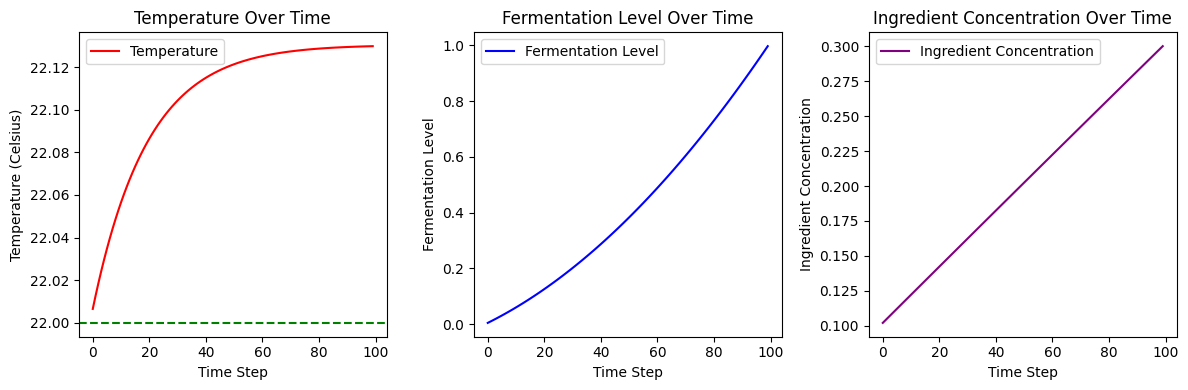

[21] loss: 0.133


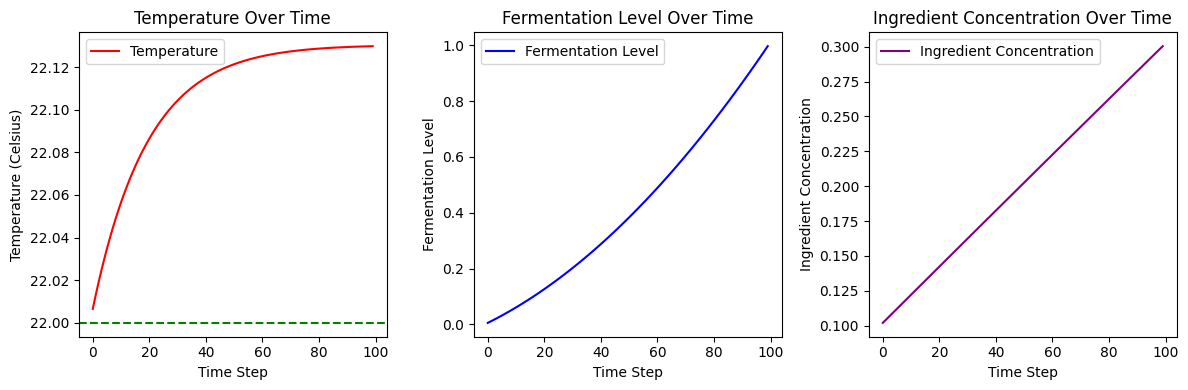

[22] loss: 0.132


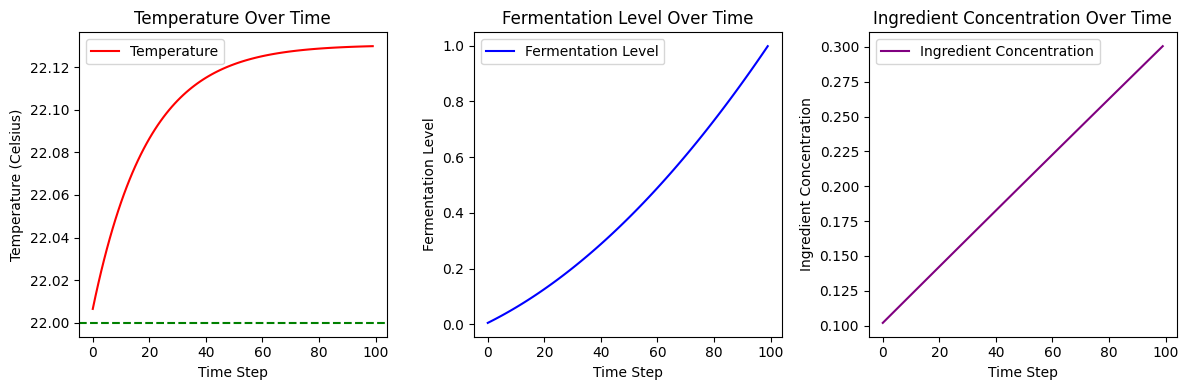

[23] loss: 0.132


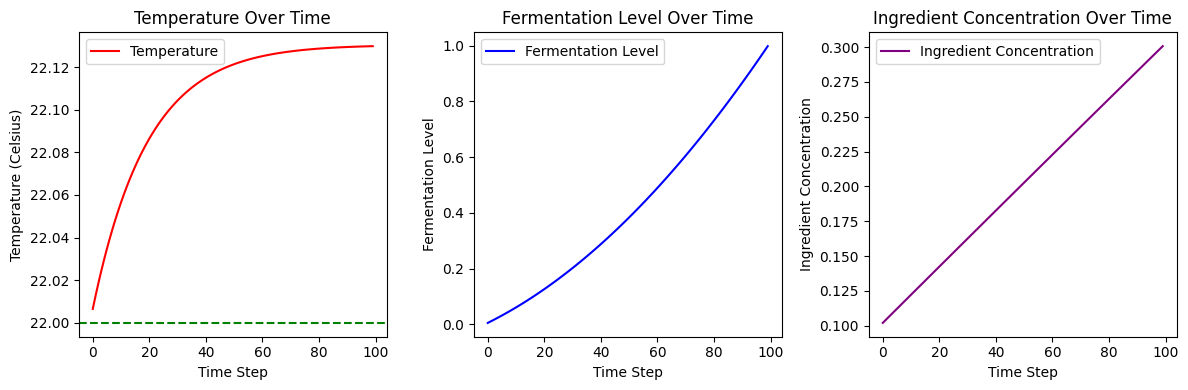

[24] loss: 0.131


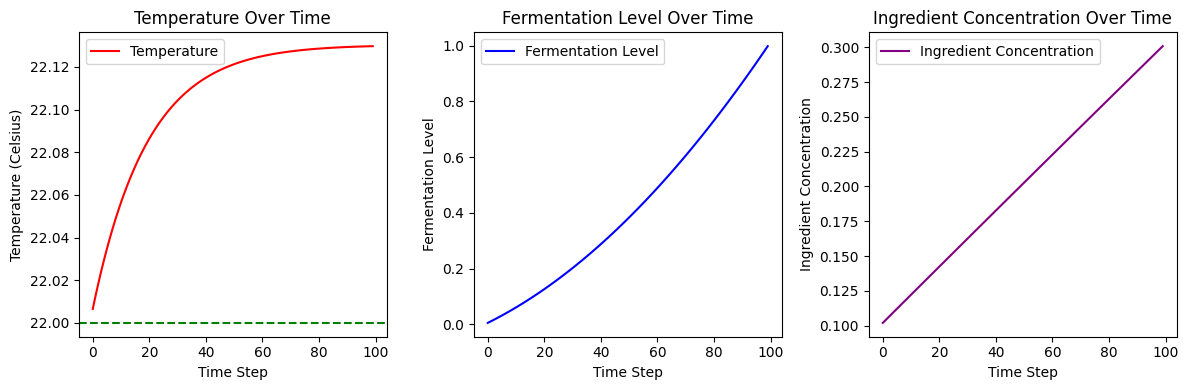

[25] loss: 0.131


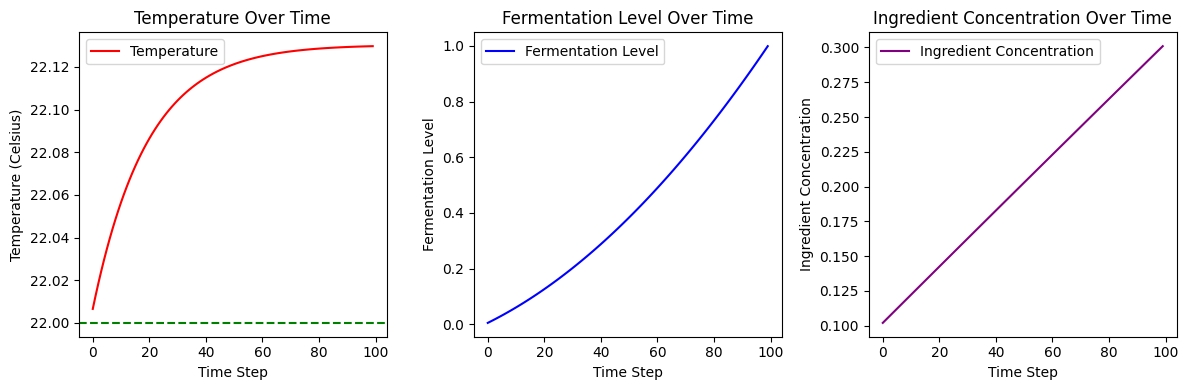

[26] loss: 0.131


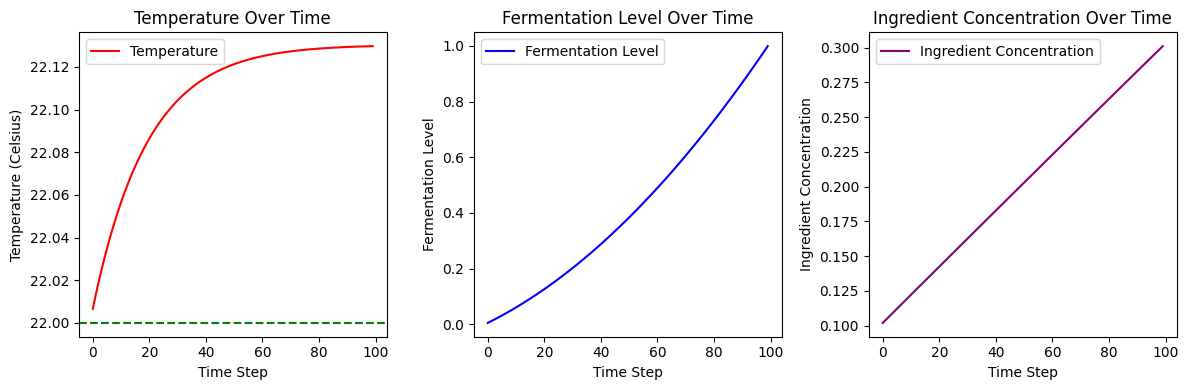

[27] loss: 0.130


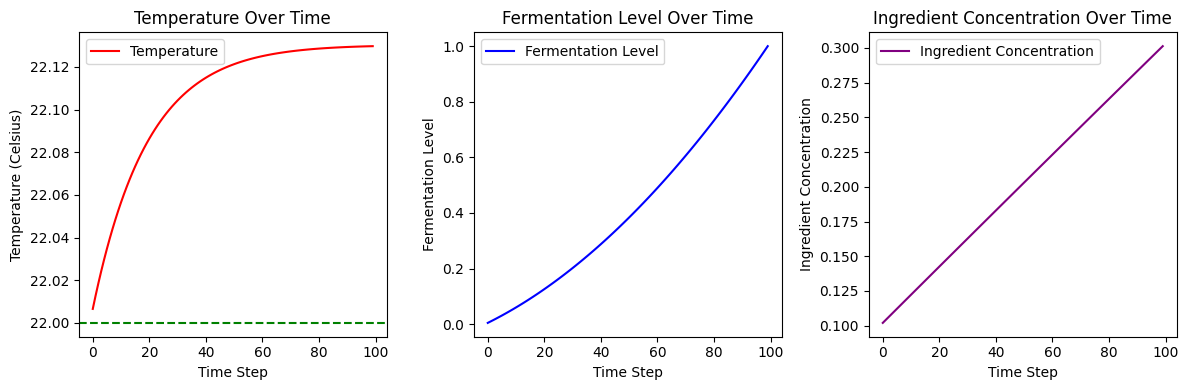

[28] loss: 0.127


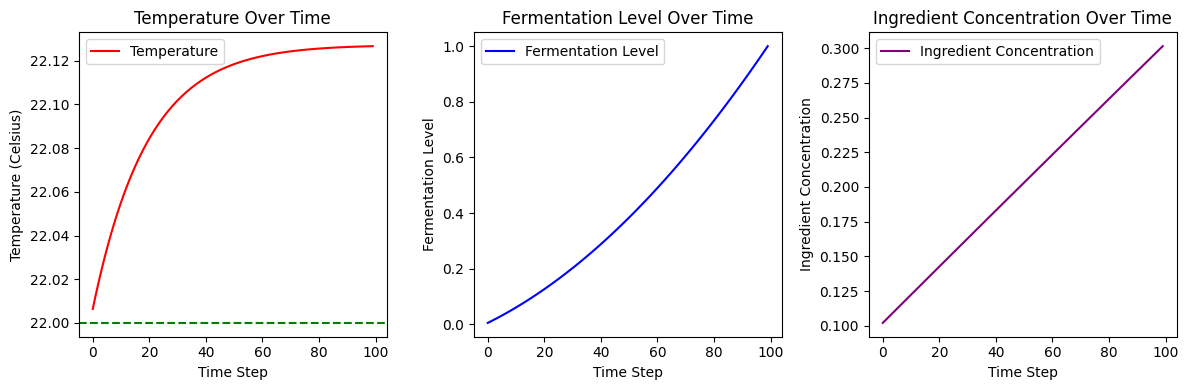

[29] loss: 0.101


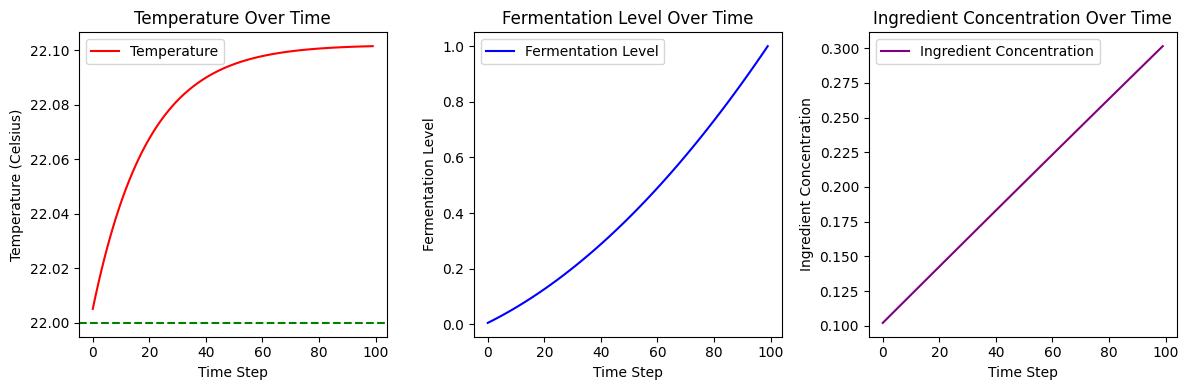

[30] loss: 0.083


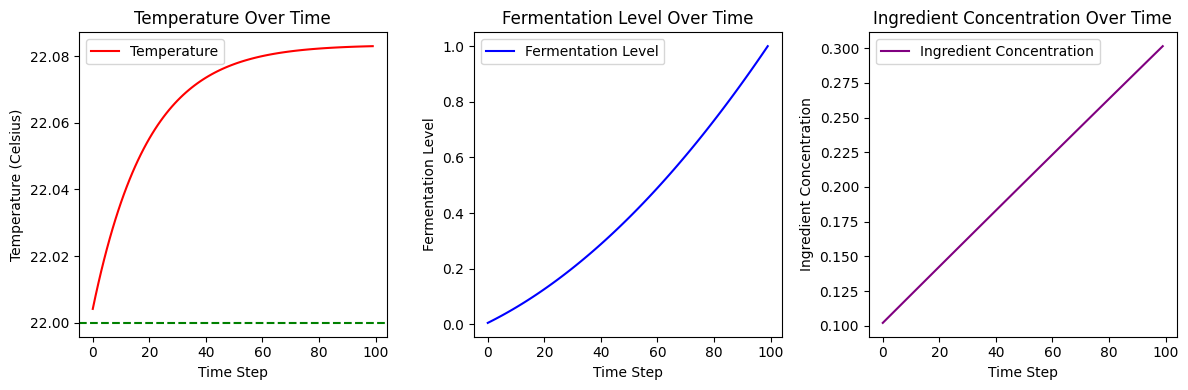

[31] loss: 0.067


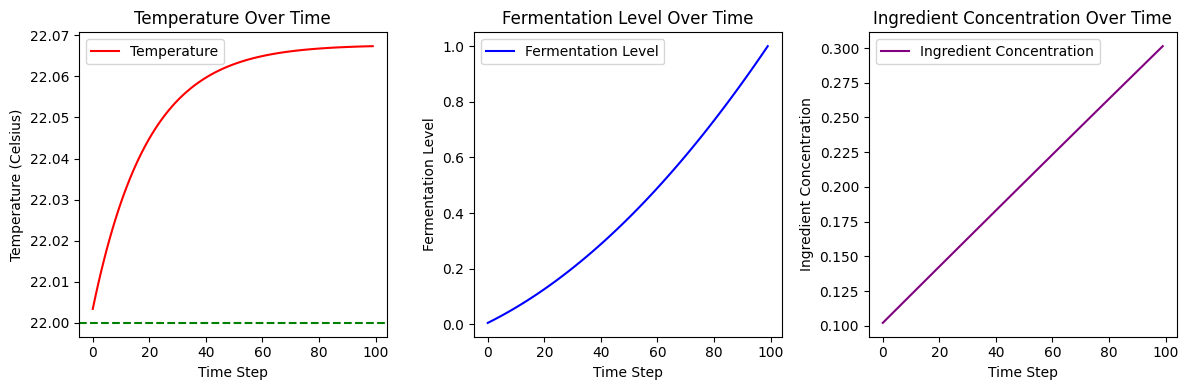

[32] loss: 0.054


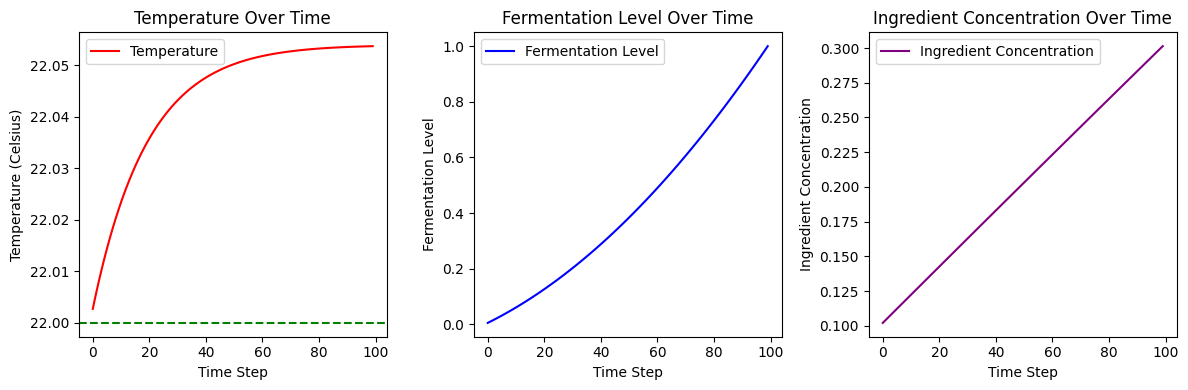

[33] loss: 0.054


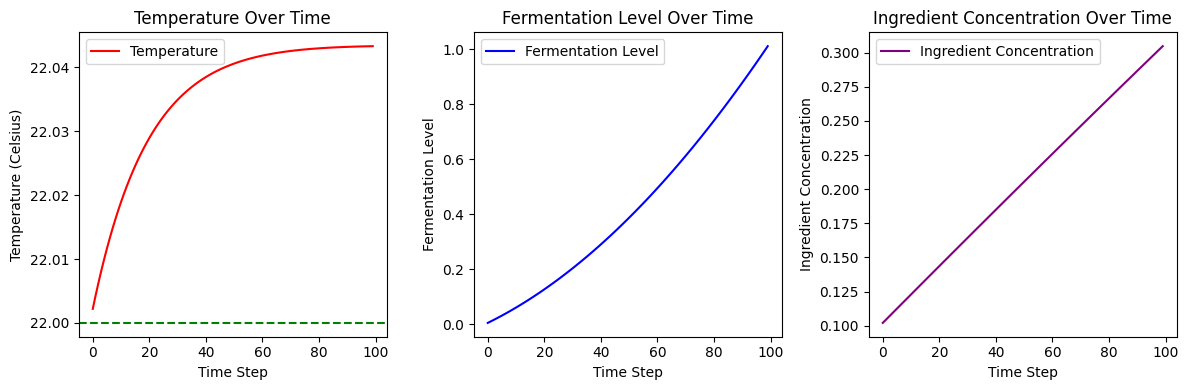

[34] loss: 0.041


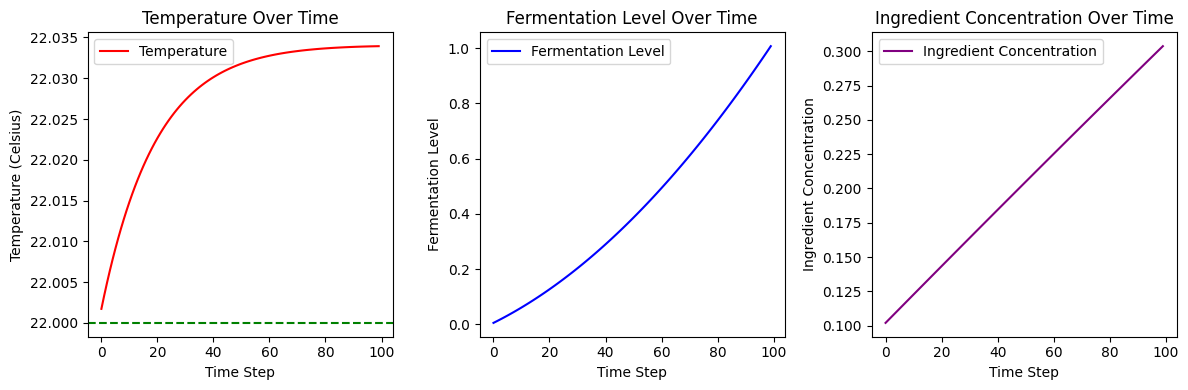

[35] loss: 0.033


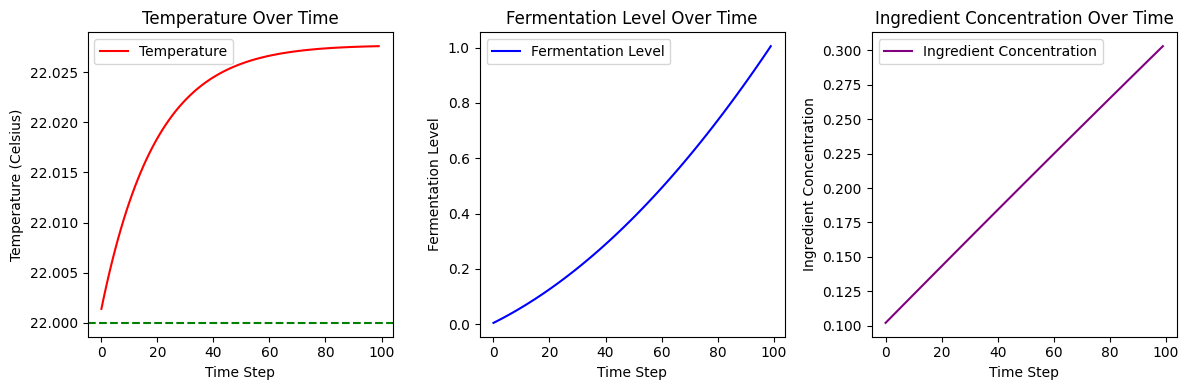

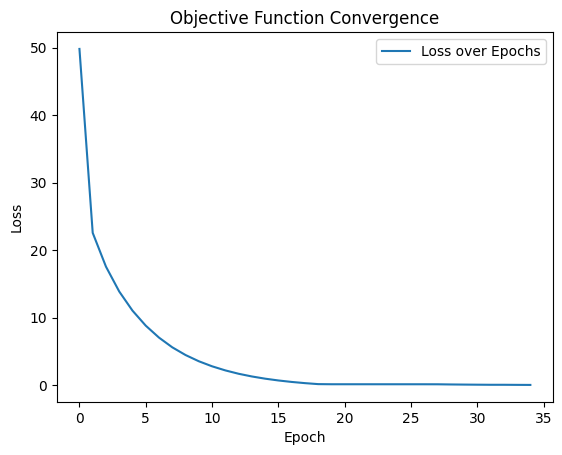

Length of state_trajectory: 100


'brewing_process_3d.gif'

In [11]:
# Simulation parameters
T = 100  # Number of time steps
dim_input = 3  # State dimensions
dim_hidden = 10
dim_output = 2  # Control actions

# Initialize the simulation
dynamics = BrewingDynamics()
controller = BrewingController(dim_input, dim_hidden, dim_output)
simulation = BrewingSimulation(controller, dynamics, T)
optimizer = BrewOptimize(simulation)

# Train
optimizer.train(35)
optimizer.plot_convergence_curve()
optimizer.animate_brewing_process_3d('brewing_process_3d.gif')

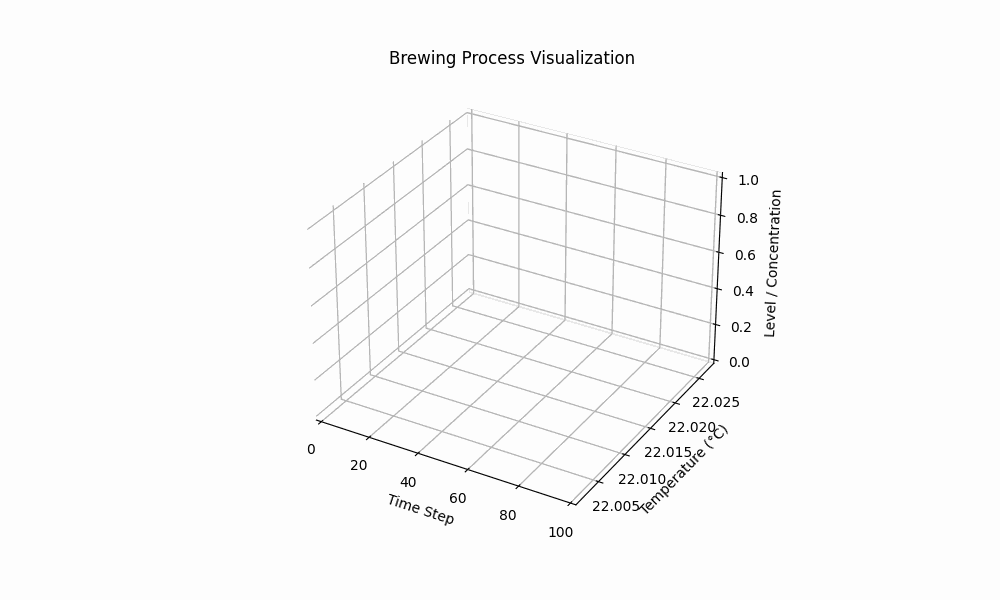

In [12]:
display(Image(filename='/content/brewing_process_3d.gif'))


### Issues and Lessons Learned

1. **Tensor Operations and Dimensionality**:
   - **Issue**: Handling tensor operations, particularly ensuring that action and state tensors align correctly in dimensions.
   - **Lesson**: Always check and match the dimensions of tensors when performing operations. Padding was used to align the action tensor with the state tensor.

2. **Hyperparameter Tuning**:
   - **Issue**: Choosing the right hyperparameters for the optimization algorithm (LBFGS) and the neural network.
   - **Lesson**: Extensive experimentation is needed to find the optimal learning rate and other hyperparameters. The choice of LBFGS was guided by its suitability for small datasets and low-dimensional problems.